<a href="https://colab.research.google.com/github/146790g/BreakHis-VGG16/blob/master/BreakHis_VGG16_2_Model_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深層学習 VGG16モデルのファイン・チューニング法を用いた乳がん染色画像の解析
##  Deep Learning for Magnification Independent Breast Cancer Histopathology
## Image Classification

#（その１： Model Fitting）

４つのMagnification levelのデータをすべて合算して、解析する

<br>

## 4 Magnification Levels: ×40, ×100, ×200, ×400


During analysis and annotation, pathologists starts by identifying ROIs in
the lowest magnification level slide (×40), then dives deeper in the latter using higher magnification levels (×100, ×200) until having a profound insight
(×400). 

<br>

## データ数 の概要

### Training Data: 5026 images <br>
###  -- Benign Data: 1472 images <br>
###  -- Mallignant Data: 3554 images 

### Validation Data: 2904 images <br>
### -- Benign Data: 1008 images <br>
### -- Mallignant Data:1896 images <br>

## Data Set Details by Magnification levels.

 ×40 : <br>
×100 : <br>
×200 : <br>
×400 : <br>

##  VGG16モデル解析についてのyoutube動画の説明

[Fine-tune VGG16 Image Classifier with Keras | Part 1: Build](https://www.youtube.com/watch?v=oDHpqu52soI&t=42s)

[Fine-tune VGG16 Image Classifier with Keras | Part 2: Train](https://www.youtube.com/watch?v=INaX55V1zpY&t=72s)

[Fine-tune VGG16 Image Classifier with Keras | Part 3: Predict](https://www.youtube.com/watch?v=HDom7mAxCdc)

In [ ]:
%tensorflow_version 2.x

In [ ]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls -lh '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data'

total 8.0K
drwx------ 2 root root 4.0K Jul 21 03:42 train
drwx------ 2 root root 4.0K Jul 27 01:49 validation


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import os
#import Pillow
#from PIL import Image
#import opencv
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np




#num_train = 1000              # 訓練データの画像数
#num_validation = 1000          # テストデータの画像数

img_h, img_w = 400,400
channels = 3
batch_size = 30               # ミニバッチのサイズ
train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/train' # 訓練データのフォルダー
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/data/validation' # テストデータのフォルダー
result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results'        # VGG16の出力結果を保存するフォルダー
test_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/test'

train_normal_files = os.listdir(os.path.join(train_data_dir,'benign'))
train_malignant_files = os.listdir(os.path.join(train_data_dir,'malignant'))
validtion_normal_files = os.listdir(os.path.join(validation_data_dir,'benign'))
validation_malignant_files = os.listdir(os.path.join(validation_data_dir,'malignant'))
    


#第３章　VGG16とFC層を結合したモデルの構築

##ファインチューニング法を用いる  
##VGG16モデルのうち、ブロック５を学習可能として、さらに、FC層は、独自で新規にモデルを構築する

In [ ]:
 ## VGG16モデルと学習済み重みを読み込む

img_h, img_w = 400,400
channels = 3
batch_size = 30  


vgg16_model = VGG16(include_top=False,        # 全結合層は層（FC）は読み込まない
                    weights='imagenet',       # ImageNetで学習した重みを利用
                    input_shape=(img_h, img_w, channels) # 入力データの形状
                   )

# VGG16モデルのサマリを出力
print('VGG16モデルのサマリ')
vgg16_model.summary()

# VGG16のblock1_conv1からblock4_poolまでを凍結
# block5のみを学習可能にする
vgg16_model.trainable = True
set_trainable = False
for layer in vgg16_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:        
        layer.trainable = True
    else:
        layer.trainable = False
    
## 凍結後のサマリを出力
print('凍結後のサマリ')
vgg16_model.summary()

## VGG16モデルと独自のFC層を連結した計算モデルを構築
# Sequentialオブジェクトを生成
model = Sequential()

# VGG16モデルを追加
model.add(vgg16_model)
# Flatten層
model.add(Flatten())
# 全結合層
model.add(Dense(256,                 # ニューロン数は256
                activation='relu'    # 活性化関数はReLU
                ))
#第８層（出力層）
model.add(Dense(1, activation='sigmoid', name='sigmoid'))

# VGG16に独自のFC層を結合したモデルのサマリを出力
print('結合後のサマリ')
model.summary()    
     
     
     
  

58892288/58889256 [==============================] - 0s 0us/step
VGG16モデルのサマリ
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________

In [ ]:
## モデルのコンパイル
# 最適化はRMSpropで行う
# 学習率を小さくしたのはファインチューニングを

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

#第4章　データ拡張

In [ ]:

img_h, img_w = 400,400
channels = 3
batch_size = 30               # ミニバッチのサイズ
#train_data_dir = 'content/data/train' # 訓練データのフォルダー
#validation_data_dir = 'content/data/validation' # テストデータのフォルダー
#result_dir = 'results'        # VGG16の出力結果を保存するフォルダー  


## 訓練データを読み込むジェネレーターを生成
# データ拡張を行う
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,      # 40度の範囲でランダムに回転させる
    width_shift_range=0.2,  # 横サイズの0.2の割合でランダムに水平移動
    height_shift_range=0.2, # 縦サイズの0.2の割合でランダムに垂直移動
    horizontal_flip=True,   # 水平方向にランダムに反転、左右の入れ替え
    vertical_flip=True,
    zoom_range=0.8,         # ランダムに拡大
    shear_range=0.2         # シアー変換をかける
)

# 訓練データを生成するするジェネレーター
train_generator = train_datagen.flow_from_directory(
    train_data_dir,             # 訓練データのフォルダー
    target_size=(img_h, img_w), # 画像をリサイズ
    batch_size=batch_size,      # ミニバッチのサイズ
    class_mode='binary'         # 出力層は二値のラベルが必要
)


## テストデータを読み込むジェネレーターを生成
test_datagen = ImageDataGenerator(rescale=1.0 / 255)


# テストデータを生成するするジェネレーター
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,        # テストデータのフォルダー
    target_size=(img_h, img_w), # 画像をリサイズ
    batch_size=batch_size,      # ミニバッチのサイズ
    class_mode='binary'         # 出力層は二値のラベルが必要
)

Found 5026 images belonging to 2 classes.
Found 2904 images belonging to 2 classes.


In [ ]:
type(train_generator)
print(train_generator.class_indices)
print(validation_generator.class_indices)


{'benign': 0, 'malignant': 1}
{'benign': 0, 'malignant': 1}


# 第5章　Model Fitting

### epochs=4としてみて、Model Fittingに対して、どれだけ時間がかかるかの想定をつける。今の場合には、最初のepochでは、5359秒を要して、2回目のepochでは、300秒を要することがわかる。そのため、この解析をepoch５０回繰り返すのに必要な時間は、以下のとおりとなる。

### ５３５９秒＋３００秒×５０＝２０３５９秒＝３３９分１９秒

### つまり、５時間４０分程度を要することがわかる。

In [ ]:
epochs=4
num_train = 5026
num_validation = 2904

## 学習を行う

# 訓練データのジェネレーターのサイズ：164
print(len(train_generator))
# 訓練データの数をミニバッチのサイズで割った値：163
print(num_train//batch_size)
# テストデータのジェネレーターのサイズ：20
print(len(validation_generator))
# テストデータの数をミニバッチのサイズで割った値：19
print(num_validation//batch_size)

# モデルのファインチューニング
history = model.fit(
    
    # 訓練データのジェネレーター
    train_generator,
    # 各エポックにおけるステップ数として
    # 訓練データの数をミニバッチのサイズで割った値を指定
    steps_per_epoch=num_train//batch_size,
    # エポック数（学習回数）
    epochs=epochs,
    # テストデータのジェネレーター
    validation_data=validation_generator,
    # テストにおける各エポックにおけるステップ数として
    # テストデータの数をミニバッチのサイズで割った値を指定
    validation_steps=num_validation//batch_size
)

168
167
97
96
Epoch 1/4
167/167 [==============================] - 5359s 32s/step - loss: 0.5454 - accuracy: 0.7268 - val_loss: 0.7019 - val_accuracy: 0.6719
Epoch 2/4
167/167 [==============================] - 305s 2s/step - loss: 0.4536 - accuracy: 0.7916 - val_loss: 0.4546 - val_accuracy: 0.7885
Epoch 3/4
167/167 [==============================] - 285s 2s/step - loss: 0.3884 - accuracy: 0.8295 - val_loss: 0.4595 - val_accuracy: 0.7920
Epoch 4/4
167/167 [==============================] - 297s 2s/step - loss: 0.3656 - accuracy: 0.8487 - val_loss: 1.0210 - val_accuracy: 0.6955


### 次に、epochを５０回として、やってみる

In [ ]:
epochs=50
num_train = 5026
num_validation = 2904

## 学習を行う

# 訓練データのジェネレーターのサイズ：164
print(len(train_generator))
# 訓練データの数をミニバッチのサイズで割った値：163
print(num_train//batch_size)
# テストデータのジェネレーターのサイズ：20
print(len(validation_generator))
# テストデータの数をミニバッチのサイズで割った値：19
print(num_validation//batch_size)

# モデルのファインチューニング
history = model.fit(
    
    # 訓練データのジェネレーター
    train_generator,
    # 各エポックにおけるステップ数として
    # 訓練データの数をミニバッチのサイズで割った値を指定
    steps_per_epoch=num_train//batch_size,
    # エポック数（学習回数）
    epochs=epochs,
    # テストデータのジェネレーター
    validation_data=validation_generator,
    # テストにおける各エポックにおけるステップ数として
    # テストデータの数をミニバッチのサイズで割った値を指定
    validation_steps=num_validation//batch_size
)

168
167
97
96
Epoch 1/50
167/167 [==============================] - 3593s 22s/step - loss: 0.5511 - accuracy: 0.7194 - val_loss: 0.6325 - val_accuracy: 0.6750
Epoch 2/50
167/167 [==============================] - 350s 2s/step - loss: 0.4505 - accuracy: 0.7872 - val_loss: 0.5991 - val_accuracy: 0.7222
Epoch 3/50
167/167 [==============================] - 339s 2s/step - loss: 0.3985 - accuracy: 0.8185 - val_loss: 0.6124 - val_accuracy: 0.7392
Epoch 4/50
167/167 [==============================] - 328s 2s/step - loss: 0.3739 - accuracy: 0.8385 - val_loss: 0.4362 - val_accuracy: 0.8083
Epoch 5/50
167/167 [==============================] - 326s 2s/step - loss: 0.3480 - accuracy: 0.8533 - val_loss: 0.4547 - val_accuracy: 0.8153
Epoch 6/50
167/167 [==============================] - 328s 2s/step - loss: 0.3295 - accuracy: 0.8621 - val_loss: 0.7940 - val_accuracy: 0.7389
Epoch 7/50
167/167 [==============================] - 327s 2s/step - loss: 0.3127 - accuracy: 0.8693 - val_loss: 0.5922 - val_

In [ ]:
result_dir = '/content/gdrive/My Drive/Colab Notebooks/BreakHis/results'  


with open(os.path.join(result_dir,'breakhis_vgg16model.json'),'w') as json_file:
  json_file.write(model.to_json())

#model parameter save
model.save_weights(os.path.join(result_dir,'breakhis_vgg16parameter.h5'))


# model save
model.save(os.path.join(result_dir,'breakhis_vgg16model_parameter.h5'))

import pandas as pd

df_history=pd.DataFrame(history.history)

df_history.to_pickle(os.path.join(result_dir,'history.pkl'))



In [ ]:
type(history)
history.history
print(history.history)


{'loss': [0.551092803478241, 0.45051196217536926, 0.3984852135181427, 0.37393486499786377, 0.34800392389297485, 0.32952556014060974, 0.3127420246601105, 0.3016822040081024, 0.2936052083969116, 0.2818565368652344, 0.27145394682884216, 0.2744475305080414, 0.25472623109817505, 0.24602122604846954, 0.2533789873123169, 0.24353879690170288, 0.24543920159339905, 0.23733265697956085, 0.22182872891426086, 0.21538546681404114, 0.2215159833431244, 0.21248319745063782, 0.21308408677577972, 0.20760853588581085, 0.20087365806102753, 0.19361788034439087, 0.20369867980480194, 0.18949414789676666, 0.19433832168579102, 0.18819007277488708, 0.1870201975107193, 0.1790132373571396, 0.17807166278362274, 0.18321698904037476, 0.18388107419013977, 0.17847508192062378, 0.16957738995552063, 0.16141211986541748, 0.16380225121974945, 0.17583294212818146, 0.169835165143013, 0.1631389856338501, 0.16002602875232697, 0.16674859821796417, 0.15076959133148193, 0.16686570644378662, 0.1604718565940857, 0.1530003398656845,

In [ ]:
np.mean(history.history['accuracy'][48:50])

0.9435548484325409

In [ ]:
np.mean(history.history['val_accuracy'][48:50])

0.8565972149372101

##【考察】
epochが、48番から50番までの精度の平均値を算出すると、  
訓練データ：精度：94.36 ％  
テストデータ：精度：85.66％  
であった。
 このことから、このVGG16モデルのファインチューニング法により構築されたモデルは、十分に妥当であると考えられる。

##第６章　モデルの評価

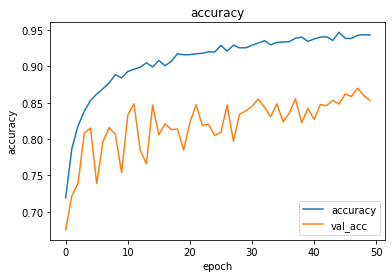

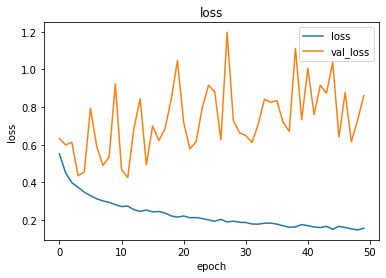

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)